In [30]:
import time
from collections import defaultdict
from statistics import mean

import torch

from s4drc.src.rt_model import S4Model
import matplotlib.pyplot as plt

In [2]:
model = S4Model().cpu().eval()

In [25]:
BUFFER_LENGTHS = [2 ** i for i in range(7, 13)]
BUFFER_NUM = 100
SR = 44100

@torch.no_grad()
def evaluate_real_time_inference_efficiency():
    inference_time_ms_dict: dict[int, float] = {}

    for length in BUFFER_LENGTHS:
        x = torch.rand(1, length).to('cpu', torch.float32)
        cond = torch.tensor([[1, 65]]).to('cpu', torch.float32)
        states = [torch.zeros([1, 32, 2]) for _ in range(4)]

        inference_time_ns: list[int] = []
        for i in range(20):
            tic = time.perf_counter_ns()
            for j in range(BUFFER_NUM):
                y, states = model(x, cond, states)
            toc = time.perf_counter_ns()
            
            inference_time_ns.append(toc - tic)
        
        inference_time_ns_mean = mean(inference_time_ns)
        inference_time_ms_mean = inference_time_ns_mean / (10 ** 6)
        inference_time_ms_dict[length] = inference_time_ms_mean
    
    return inference_time_ms_dict

inference_time_ms_dict = evaluate_real_time_inference_efficiency()

In [28]:
out = {
    'buffer': [],
    'playback_time': [],
    'inference_time': [],
    'speed_ratio': [],
}

for length, inference_time in inference_time_ms_dict.items():
    playback_time = length * BUFFER_NUM * 1000 / SR 
    speed_ratio = playback_time / inference_time

    out['buffer'].append(length)
    out['playback_time'].append(playback_time)
    out['inference_time'].append(inference_time)
    out['speed_ratio'].append(speed_ratio)

    print(f'At buffer {length = }, {playback_time = } s, {inference_time = } s, {speed_ratio = }')

At buffer length = 128, playback_time = 290.24943310657596 s, inference_time = 388.76738745 s, speed_ratio = 0.7465889436106711
At buffer length = 256, playback_time = 580.4988662131519 s, inference_time = 511.5669165 s, speed_ratio = 1.1347466919572622
At buffer length = 512, playback_time = 1160.9977324263039 s, inference_time = 686.69037485 s, speed_ratio = 1.6907150222979477
At buffer length = 1024, playback_time = 2321.9954648526077 s, inference_time = 1046.69061865 s, speed_ratio = 2.2184162382648176
At buffer length = 2048, playback_time = 4643.990929705215 s, inference_time = 1803.0496186500002 s, speed_ratio = 2.575631242573522
At buffer length = 4096, playback_time = 9287.98185941043 s, inference_time = 3136.57941245 s, speed_ratio = 2.9611817964958


/var/folders/w5/x13bz9k967g2pwqn4y2yqmx40000gn/T/ipykernel_58994/2266064907.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


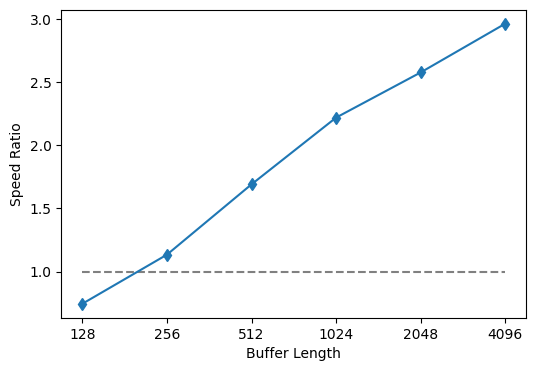

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hlines([1.0], 0, len(BUFFER_LENGTHS) - 1, color='grey', linestyles='dashed')
ax.plot(list(map(str, out['buffer'])), out['speed_ratio'], marker='d')
ax.set_xlabel('Buffer Length')
ax.set_ylabel('Speed Ratio')

fig.show()
fig.savefig('speed-ratio.png')